In [9]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
from rdkit import Chem
from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
c:\Users\predator\anaconda3\envs\dili\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Users\predator\anaconda3\envs\dili\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'
Skipped loading

# Data preparation

In [10]:
smiles = "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"
tokenizer = BasicSmilesTokenizer()
tokens = tokenizer.tokenize(smiles)
print("Tokenized SMILES:", tokens)

Tokenized SMILES: ['C', 'C', '(', 'C', ')', 'C', 'C', '1', '=', 'C', 'C', '=', 'C', '(', 'C', '=', 'C', '1', ')', 'C', '(', 'C', ')', 'C', '(', '=', 'O', ')', 'O']


In [14]:
# Load pd_train
pd_train = pd.read_csv("data_smiles/Training_Group.csv")
pd_train["label"] = pd_train["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)
pd_train["label"].value_counts()
print(pd_train.head())

(1241, 3)
                                              Smiles           Liver  label
0                              S=C=Nc1c2c(ccc1)cccc2  Hepatotoxicity      1
1  c1(c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[...  Hepatotoxicity      1
2            c1(c(cc(cc1)[N+](=O)[O-])[N+](=O)[O-])O  Hepatotoxicity      1
3                                           O(CCO)CC  Hepatotoxicity      1
4                                  Oc1cc2c(cc1)cccc2  Hepatotoxicity      1


In [15]:
# Load pd_test
pd_test = pd.read_csv("data_smiles/Testing_Group.csv")
pd_test["label"] = pd_test["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)
pd_test["label"].value_counts()
print(pd_test.head())

(286, 3)
                                              Smiles           Liver  label
0  C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN...  Hepatotoxicity      1
1                      C=CCOC1=C(C=C(C=C1)CC(=O)O)Cl  Hepatotoxicity      1
2  CCCN(CCC)C(=O)CC1=C(N=C2N1C=C(C=C2)Cl)C3=CC=C(...  Hepatotoxicity      1
3         C1CC2=CC=CC=C2C(C3=CC=CC=C31)NCCCCCCC(=O)O  Hepatotoxicity      1
4          C1=CC=C(C=C1)CN2C3=CC=CC=C3C(=N2)OCC(=O)O  Hepatotoxicity      1


In [18]:
pd_train["dataset"] = "train"
pd_test["dataset"] = "test"
df = pd.concat([pd_train, pd_test])
print(df.shape)
df["dataset"].value_counts()

(1527, 4)


dataset
train    1241
test      286
Name: count, dtype: int64

In [25]:
def get_freqs(df):
    freqs = defaultdict(lambda: 0)
    for idx, row in df.iterrows():
        smiles = row["Smiles"]
        label = row["label"]

        tokens = tokenizer.tokenize(smiles)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1

    return freqs


def get_feature(smiles, freqs):
    tokens = tokenizer.tokenize(smiles)

    X = np.zeros(3)
    X[0] = 1

    for token in tokens:
        X[1] += freqs[(token, 0)]
        X[2] += freqs[(token, 1)]

    return X


def get_dataset(df, freqs):
    X = []
    y = []

    for idx, row in df.iterrows():
        smiles = row["Smiles"]
        label = row["label"]
        X.append(get_feature(smiles, freqs))
        y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [38]:
freqs = get_freqs(df)
X_train, y_train = get_dataset(pd_train, freqs)
print(X_train.shape, y_train.shape)

X_test, y_test = get_dataset(pd_test, freqs)
print(X_test.shape, y_test.shape)

(1241, 3) (1241,)
(286, 3) (286,)


In [39]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

# Model training

In [40]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)

    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()


def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)

    return y_hat


def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size


def update_theta(theta, gradient, lr):
    return theta - lr * gradient


def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()

    return acc

In [41]:
lr = 0.01
epochs = 200
batch_size = 128
random_state = 2

np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])

In [42]:
train_accs = []
train_losses = []
test_accs = []
test_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    test_batch_losses = []
    test_batch_accs = []

    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i : i + batch_size]
        y_i = y_train[i : i + batch_size]

        y_hat = predict(X_i, theta)

        train_loss = compute_loss(y_hat, y_i)

        gradient = compute_gradient(X_i, y_i, y_hat)

        theta = update_theta(theta, gradient, lr)

        train_batch_losses.append(train_loss)

        train_acc = compute_accuracy(X_train, y_train, theta)
        train_batch_accs.append(train_acc)

        y_test_hat = predict(X_test, theta)
        test_loss = compute_loss(y_test_hat, y_test)
        test_batch_losses.append(test_loss)

        test_acc = compute_accuracy(X_test, y_test, theta)
        test_batch_accs.append(test_acc)

    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    test_batch_loss = sum(test_batch_losses) / len(test_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    test_batch_acc = sum(test_batch_accs) / len(test_batch_accs)

    train_losses.append(train_batch_loss)
    test_losses.append(test_batch_loss)
    train_accs.append(train_batch_acc)
    test_accs.append(test_batch_acc)

    print(
        f"\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\ttestidation loss: {test_batch_loss:.3f}"
    )


EPOCH 1:	Training loss: 0.734	testidation loss: 0.628

EPOCH 2:	Training loss: 0.732	testidation loss: 0.627

EPOCH 3:	Training loss: 0.730	testidation loss: 0.626

EPOCH 4:	Training loss: 0.728	testidation loss: 0.626

EPOCH 5:	Training loss: 0.726	testidation loss: 0.625

EPOCH 6:	Training loss: 0.724	testidation loss: 0.625

EPOCH 7:	Training loss: 0.722	testidation loss: 0.624

EPOCH 8:	Training loss: 0.721	testidation loss: 0.624

EPOCH 9:	Training loss: 0.719	testidation loss: 0.623

EPOCH 10:	Training loss: 0.717	testidation loss: 0.623

EPOCH 11:	Training loss: 0.716	testidation loss: 0.622

EPOCH 12:	Training loss: 0.714	testidation loss: 0.622

EPOCH 13:	Training loss: 0.713	testidation loss: 0.622

EPOCH 14:	Training loss: 0.711	testidation loss: 0.621

EPOCH 15:	Training loss: 0.710	testidation loss: 0.621

EPOCH 16:	Training loss: 0.708	testidation loss: 0.621

EPOCH 17:	Training loss: 0.707	testidation loss: 0.621

EPOCH 18:	Training loss: 0.706	testidation loss: 0.621



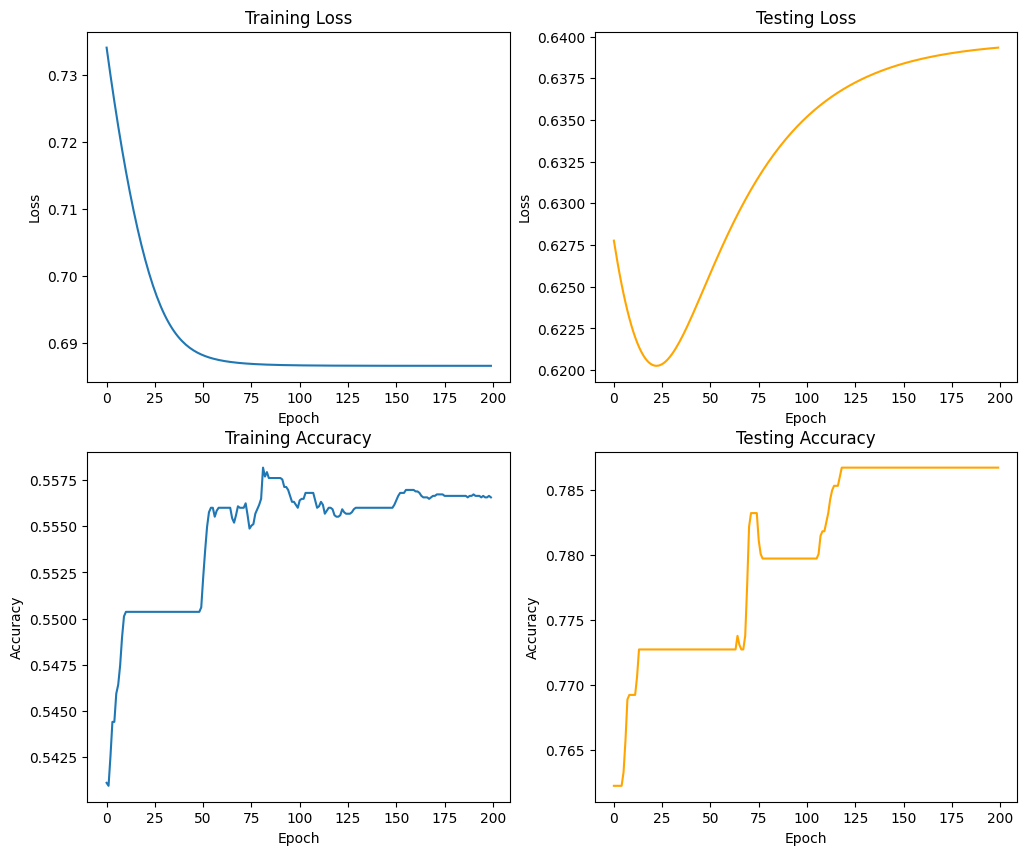

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel="Epoch", ylabel="Loss")
ax[0, 0].set_title("Training Loss")

ax[0, 1].plot(test_losses, "orange")
ax[0, 1].set(xlabel="Epoch", ylabel="Loss")
ax[0, 1].set_title("Testing Loss")

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 0].set_title("Training Accuracy")

ax[1, 1].plot(test_accs, "orange")
ax[1, 1].set(xlabel="Epoch", ylabel="Accuracy")
ax[1, 1].set_title("Testing Accuracy")

plt.show()

In [44]:
test_set_acc = compute_accuracy(X_test, y_test, theta)
print("Evaluation on validation and test set:")
print(f"Accuracy: {test_set_acc}")

Evaluation on validation and test set:
Accuracy: 0.7867132867132867


# Hyper-param tuning

In [49]:
from tpot import TPOTClassifier

# Set up TPOT with basic configuration
tpot = TPOTClassifier(
    generations=10,
    population_size=40,
    verbosity=2,
    scoring="roc_auc",  # AUC
    random_state=42,
    n_jobs=6,  # Use 4 cores
)

# Fit the model
tpot.fit(X_train, y_train)

                                                                             
Generation 1 - Current best internal CV score: 0.5435572226523279
                                                                              
Generation 2 - Current best internal CV score: 0.563954902216361
                                                                              
Generation 3 - Current best internal CV score: 0.5650198367224183
                                                                              
Generation 4 - Current best internal CV score: 0.5650198367224183
                                                                              
Generation 5 - Current best internal CV score: 0.5650198367224183
                                                                              
Generation 6 - Current best internal CV score: 0.5650198367224183
                                                                              
Generation 7 - Current best internal CV score: 0.5716

TPOTClassifier(generations=10, n_jobs=6, population_size=40, random_state=42,
               scoring='roc_auc', verbosity=2)

In [50]:
# calculate accuracy
test_set_acc = tpot.score(X_test, y_test)
print("Evaluation on validation and test set:")
print(f"Accuracy: {test_set_acc}")

Evaluation on validation and test set:
Accuracy: 0.6900104420466411


In [52]:
# calculate precision, recall
from sklearn.metrics import precision_score, recall_score

y_test_hat = tpot.predict(X_test)
precision = precision_score(y_test, y_test_hat)
recall = recall_score(y_test, y_test_hat)
print(f"Precision: {precision:.3f}\tRecall: {recall:.3f}")

Precision: 0.773	Recall: 1.000


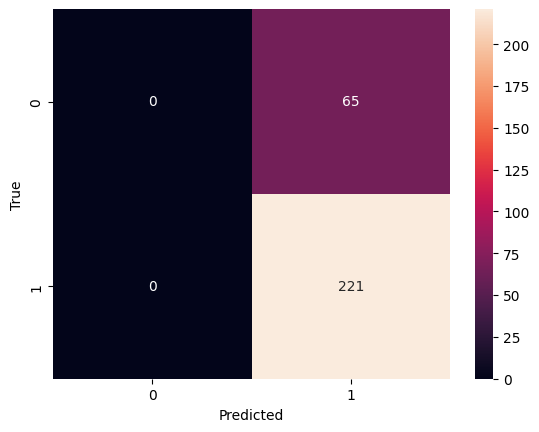

In [55]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_test_hat)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()